In [1]:
import os
import time
import sys
import matplotlib.pyplot as plt
import numpy as np 
import matplotlib.cm as cm
import matplotlib.image as plimg
import scipy.ndimage.interpolation as spndint
def showError(message):
        raise Exception(message)
import pandas as pd 


In [2]:
import dask
from distributed import Client, LocalCluster, WorkerPlugin
import multiprocessing
import dask.dataframe as dd
import numpy as np
import pandas as pd
import os
from random import choices
from natsort import natsorted
import math
from itertools import product
import random
import psutil
import sys
#current_path = os.getcwd()
#parent_dir = os.path.join(current_path, "..")
#sys.path.append(parent_dir)
import utility.alma as ual
import utility.astro as uas
import utility.compute as uc
import warnings
from os.path import isfile, expanduser
import subprocess

RED = '\033[31m'
BLUE = '\033[34m'
YELLOW = '\033[33m'
RESET = '\033[0m'

warnings.simplefilter(action="ignore", category=UserWarning)
MALLOC_TRIM_THRESHOLD_ = 0
class MemoryMonitor(WorkerPlugin):
    def __init__(self, memory_limit):
        memory_limit = memory_limit

    def setup(self, worker):
        worker = worker
        process = psutil.Process()
        process_memory_limit = memory_limit * 1024 * 1024 * 1024  # Convert GB to bytes

    async def monitor_memory(self):
        while True:
            memory_usage = self.process.memory_info().rss
            if memory_usage > self.process_memory_limit:
                print("Memory limit exceeded. Closing worker.")
                await self.worker.close(close_workers=True)
                break
            await asyncio.sleep(1)

class MemoryLimitPlugin(WorkerPlugin):
    def __init__(self, memory_limit):
        self.memory_limit = memory_limit

    def setup(self, worker):
        pass

    def teardown(self, worker):
        pass

    def transition(self, key, start, finish, *args, **kwargs):
        if finish == 'memory' and psutil.virtual_memory().percent > self.memory_limit:
            # If memory usage exceeds the limit, skip the task
            return 'erred'

if __name__ == '__main__':
    # Creating Working directories
    main_path = os.getcwd()
    #output_dir = input("Insert absolute path of the output directory, if this is the first time running ALMASim this directory will be created: ")
    #output_dir = "/srv/Fast01/delliven/almasim-test-24-5-14"
    output_dir = '/Users/michele/Documents/almasim-test-24-5-18'
    #tng_dir = input("Insert absolute path of the TNG directory, if this is the firt time running ALMASim this directory will be created: ")
    tng_dir = "/Users/michele/Documents/TNGData"
    #project_name = input(f"{RED}Insert the name of the project: {RESET}")
    project_name = 'test-int'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    if not os.path.exists(tng_dir):
        os.makedirs(tng_dir)
    output_path = os.path.join(output_dir, project_name)
    if not os.path.exists(os.path.join(output_dir, project_name)):
        os.makedirs(output_path)
    plot_dir = os.path.join(output_path, "plots")
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    
    
    # Getting Sims Configuration
    #n_sims = input(f"{BLUE}Insert number of simulations to run: {RESET}")
    n_sims = 1
    try:
        n_sims = int(n_sims)
    except ValueError:
        print(f"{YELLOW}Invalid input. Please insert an integer.{RESET}")
        n_sims = input(f"{BLUE}Insert number of simulations to run: {RESET}")
        n_sims = int(n_sims)
    
    sim_idxs = np.arange(n_sims)
    #ncpu = input(f"{RED}Insert total number of CPUs to use: {RESET}")
    ncpu = 10
    try:
        ncpu = int(ncpu)
    except ValueError:
        print(f"{YELLOW}Invalid input. Please insert an integer.{RESET}")
        ncpu = input(f"{BLUE}Insert total number of CPUs to use: {RESET}")
        ncpu = int(ncpu)
    #query = input(f'{BLUE}Do you want to query for metadata or get an available file stored in the metadata directory? (query/get) {RESET}')
    query = 'get'
    if query != 'query' and query != 'get':
        print(f"{YELLOW}Invalid input. Please insert query or get.{RESET}")
        query = input(f'{RED}Do you want to query for metadata or get an available file stored in the metadata directory? (query/get) {RESET}')
    if query == 'query':
        query_mode = input(f"{BLUE}Do you have a target list for the ALMA Database or do you want to query by science case? (target/science): {RESET}")
        if query_mode != "target" and query_mode != "science":
            print(f"{YELLOW}Invalid input. Please insert target or science.{RESET}")
            query_mode = input(f"{RED}Do you have a target list for the ALMA Database or do you want to query by science case? (target/science): {RESET}")
        if query_mode == "target":
            target_list = input(f"{BLUE}Insert the absolute path of the target list .csv file. This file should contain two columns with the target name and the target uid: {RESET}")
            if not isfile(target_list):
                print(f"{YELLOW}File not found.{RESET}")
                target_list = input(f"{RED}File not found. Please provide the correct path: {RESET}")
            target_list = pd.read_csv(target_list).values
            target_list = target_list.tolist()
            metadata_name = input(f"{BLUE}Queried metadata will be saved as a .csv file in the metadata folder: {RESET}")
            metadata = ual.query_for_metadata_by_targets(target_list, os.path.join(main_path, "metadata", metadata_name))
        else:
            metadata_name = input(f"{RED}Queried metadata will be saved as a .csv file in the metadata folder: {RESET}")
            if '.csv' not in metadata_name:
                metadata_name = metadata_name.split('.')[0]
                metadata_name = metadata_name + '.csv'
            metadata = ual.query_for_metadata_by_science_type(metadata_name, main_path)
    else:
        #metadata_name = input(f"{BLUE}Insert the name of the metadata file you want to use. Make sure to add .csv: {RESET}")
        metadata_name = 'AGN_all_bands'
        if '.csv' not in metadata_name:
            metadata_name = metadata_name.split('.')[0]
            metadata_name = metadata_name + '.csv'
        metadata = uc.load_metadata(main_path, metadata_name)
    #line_mode = input(f"{RED}Do you want to simulate a specific line/s? (y/n) {RESET}")
    line_mode = 'n'
    if line_mode != "y" and line_mode != "n":
        print(f"{YELLOW}Invalid input. Please insert y or n.{RESET}")
        line_mode = input(f"{BLUE}Do you want to simulate a specific line/s? (y/n) {RESET}")
    if line_mode == "y":
        uas.line_display(main_path)
        line_idxs = input(f"{RED}Select the line/s you want to simulate, separated by a space: {RESET}")
        line_idxs = [int(ix) for ix in line_idxs.split(' ')]
        rest_freq, line_names = uas.get_line_info(main_path, line_idxs)
        if len(rest_freq) == 1:
            rest_freq = rest_freq[0]
        rest_freqs = np.array([rest_freq]*n_sims)
        redshifts = np.array([None]*n_sims)
        n_lines = np.array([None]*n_sims)
        line_names = np.array([line_names]*n_sims)
        z1 = None
    else:
        #redshifts = input(f'{BLUE}Please provide the boundaries of the redshift interval you want to simulate as two float or integers separated by a space. If a single value is given, all simualtions will be performed at the same redshift: {RESET}')
        redshifts = '0.2'
        redshifts = redshifts.split()
        if len(redshifts) == 1:
            redshifts = np.array([float(redshifts[0])] * n_sims)
            z0, z1 = float(redshifts[0]), float(redshifts[0])
        else:
            z0, z1 = float(redshifts[0]), float(redshifts[1])
            redshifts = np.random.uniform(z0, z1, n_sims)
        #n_lines = input(f'{RED}Please provide the number of lines you want to simulate as an integer: {RESET}')
        n_lines = '1'
        n_lines = np.array([int(n_lines)]*n_sims)
        rest_freq, _ = uas.get_line_info(main_path)
        line_names = np.array([None]*n_sims)
        rest_freqs = np.array([None]*n_sims)
    
    #set_infrared = input(f'{BLUE}Do you want to provide infrared luminosities for SED normalization? (y/n), if not provided, they will be automatically computed based on the minimum continuum flux observable by the ALMA configuration: {RESET}')
    set_infrared  = 'y'
    if set_infrared != "y" and set_infrared != "n":
        print(f"{YELLOW}Invalid input. Please insert y or n.{RESET}")
        set_infrared = input(f'{BLUE}Do you want to provide infrared luminosities for SED normalization? (y/n), if not provided, they will be automatically computed based on the minimum continuum flux observable by the ALMA configuration: {RESET}')
    if set_infrared == "y":
        #lum_infrared = input(f'{RED}Insert infrared luminosity (in solar masses), you can input a single value, or an interval as two floats (es. 1e10) separated by a space: {RESET}')
        lum_infrared = '1e12'
        lum_infrared = [float(lum) for lum in lum_infrared.split()]
        if len(lum_infrared) == 1:
            lum_ir = np.array([lum_infrared[0]]*n_sims)
        else:
            lum_ir = np.random.uniform(lum_infrared[0], lum_infrared[1], n_sims)
    else:
        lum_ir = np.array([None]*n_sims)
    #set_snr = input(f'{RED}Do you want to provide a desired SNR for the simulated observations? (y/n) {RESET}')
    set_snr = 'n'
    if set_snr != "y" and set_snr != "n":
        print(f"{YELLOW}Invalid input. Please insert y or n.{RESET}")
        set_snr = input(f'{BLUE}Do you want to provide a desired SNR for the simulated observations? (y/n) {RESET}')
    if set_snr == "y":
        snr = input(f'{RED}Please provide the desired SNR as a float or an interval as two floats separated by a space: {RESET}')
        snr = [float(snr) for snr in snr.split()]
        if len(snr) == 1:
            snr = np.array([snr[0]]*n_sims)
        else:
            snr = np.random.uniform(snr[0], snr[1], n_sims)
    else:
        snr = np.ones(n_sims)
    
    #fix_spatial = input(f'{BLUE}Do you want to fix cube spatial dimensions? (y/n) {RESET}')
    fix_spatial = 'n'
    if fix_spatial != 'y' and fix_spatial != 'n':
        print(f"{YELLOW}Invalid input. Please insert y or n.{RESET}")
        fix_spatial = input(f'{RED}Do you want to fix cube spatial dimensions? (y/n) {RESET}')
    
    if fix_spatial == 'y':
        #n_pix = input(f'{BLUE}Insert the desired cube dimension in pixels: {RESET}')
        n_pix = '256'
        n_pix = int(n_pix)
    else:
        n_pix = None
    #fix_spectral = input(f'{RED}Do you want to fix cube spectral dimensions? (y/n) {RESET}')
    fix_spectral = 'y'
    if fix_spectral != 'y' and fix_spectral != 'n':
        print(f"{YELLOW}Invalid input. Please insert y or n.{RESET}")
        fix_spectral = input(f'{BLUE}Do you want to fix cube spectral dimensions? (y/n) {RESET}')
    if fix_spectral == 'y':
        #n_channels = input(f'{RED}Insert the desired number of channels: {RESET}')
        n_channels = '256'
        n_channels = int(n_channels)
    else:
        n_channels = None
    #source_type = input(f'{BLUE}Insert source type you want to simulate (point, gaussian, extended, diffuse): {RESET}')
    source_type = 'gaussian'
    if source_type != 'point' and source_type != 'gaussian' and source_type != 'extended' and source_type != 'diffuse':
        print(f"{YELLOW}Invalid input. Please insert point, gaussian, extended or diffuse.{RESET}")
        source_type = input(f'{RED}Insert source type you want to simulate (point, gaussian, extended, diffuse): {RESET}')
    if source_type == 'extended':
        print('Checking TNG Folders')
        if not os.path.exists(os.path.join(tng_dir, 'TNG100-1')):
            os.makedirs(os.path.join(tng_dir, 'TNG100-1'))
        if not os.path.exists(os.path.join(tng_dir, 'TNG100-1', 'output')):
            os.makedirs(os.path.join(tng_dir, 'TNG100-1', 'output'))
        if not os.path.exists(os.path.join(tng_dir, 'TNG100-1', 'postprocessing')):
            os.makedirs(os.path.join(tng_dir, 'TNG100-1', 'postprocessing'))
        if not os.path.exists(os.path.join(tng_dir, 'TNG100-1', 'postprocessing', 'offsets')):
            os.makedirs(os.path.join(tng_dir, 'TNG100-1', 'postprocessing', 'offsets'))
    
        print('Checking simulation file')
        tng_api_key = '8f578b92e700fae3266931f4d785f82c'
        if not isfile(os.path.join(tng_dir, 'TNG100-1', 'simulation.hdf5')):
            print('Downloading simulation file')
            url = "http://www.tng-project.org/api/TNG100-1/files/simulation.hdf5"
            cmd = "wget -nv --content-disposition --header=API-Key:{} -O {} {}".format(tng_api_key, os.path.join(tng_dir, 'TNG100-1', 'simulation.hdf5'), url)
            subprocess.check_call(cmd, shell=True)
            print('Done.')
    
        tng_apis = [str(tng_api_key)*n_sims]
    else:
        tng_apis = np.array([None]*n_sims)    
    
    if source_type == 'extended': 
        metadata = uas.sample_given_redshift(metadata, n_sims, rest_freq, True, z1)
    else:
        metadata = uas.sample_given_redshift(metadata, n_sims, rest_freq, False, z1)
    print('\nMetadata retrieved\n')
    #inject_ser = input(f'{RED}Do you want to inject serendipitous sources? (y/n) {RESET}')
    inject_ser = 'n'
    if inject_ser != 'y' and inject_ser != 'n':
        print(f"{YELLOW}Invalid input. Please insert y or n.{RESET}")
        inject_ser = input(f'{BLUE}Do you want to inject serendipitous sources? (y/n) {RESET}')
    if inject_ser == 'y':
        inject_serendipitous = np.array([True] * n_sims)
    else:
        inject_serendipitous = np.array([False] * n_sims)
    ras = metadata['RA'].values
    decs = metadata['Dec'].values
    bands = metadata['Band'].values
    ang_ress = metadata['Ang.res.'].values
    vel_ress = metadata['Vel.res.'].values
    fovs = metadata['FOV'].values
    obs_dates = metadata['Obs.date'].values
    pwvs = metadata['PWV'].values
    int_times = metadata['Int.Time'].values
    total_times = metadata['Total.Time'].values
    bandwidths = metadata['Bandwidth'].values
    freqs = metadata['Freq'].values
    freq_supports = metadata['Freq.sup.'].values
    antenna_arrays = metadata['antenna_arrays'].values
    cont_sens = metadata['Cont_sens_mJybeam'].values
    n_pixs = np.array([n_pix]*n_sims)
    n_channels = np.array([n_channels]*n_sims)
    source_types = np.array([source_type]*n_sims)
    output_paths = np.array([output_path]*n_sims)
    tng_paths = np.array([tng_dir]*n_sims)
    main_paths = np.array([main_path]*n_sims)
    ncpus = np.array([ncpu]*n_sims)
    project_names = np.array([project_name]*n_sims)
    save_secondary = 'y'
    if save_secondary == 'y':
        save_secondary = True
    else:
        save_secondary = False
    save_secondary = np.array([save_secondary]*n_sims)
    
    input_params = pd.DataFrame(zip(
        sim_idxs, main_paths, output_paths, tng_paths, project_names, ras, decs, bands, ang_ress, vel_ress, fovs, 
        obs_dates, pwvs, int_times, total_times, bandwidths, freqs, freq_supports, cont_sens,
        antenna_arrays, n_pixs, n_channels, source_types,
        tng_apis, ncpus, rest_freqs, redshifts, lum_ir, snr,
        n_lines, line_names, save_secondary, inject_serendipitous), 
        columns = ['idx', 'main_path', 'output_dir', 'tng_dir', 'project_name', 'ra', 'dec', 'band', 
        'ang_res', 'vel_res', 'fov', 'obs_date', 'pwv', 'int_time', 'total_time', 'bandwidth', 
        'freq', 'freq_support', 'cont_sens', 'antenna_array', 'n_pix', 'n_channels', 'source_type',
        'tng_api_key', 'ncpu', 'rest_frequency', 'redshift', 'lum_infrared', 'snr',
        'n_lines', 'line_names', 'save_secondary', 'inject_serendipitous'])

    # Dask utils
    #dask.config.set({'temporary_directory': output_path})
    total_memory = psutil.virtual_memory().total
    num_processes = multiprocessing.cpu_count() // 4
    memory_limit = int(0.9 * total_memory / num_processes)

Metadata contains 2373 samples
Max frequency recorded in metadata: 866.1293553234451
Min frequency recorded in metadata: 43.16941850591954
Filtering metadata based on line catalogue...
Remaining metadata: 2372
Computing redshifts
Remaining metadata: 47

Metadata retrieved



In [3]:
inx, main_dir, output_dir, tng_dir, project_name, ra, dec, band, ang_res, vel_res, fov, obs_date, \
    pwv, int_time, total_time, bandwidth, freq, freq_support, cont_sens, antenna_array, n_pix, \
    n_channels, source_type, tng_api_key, ncpu, rest_frequency, redshift, lum_infrared, snr, \
        n_lines, line_names, save_secondary, inject_serendipitous = input_params.values.T
inx = inx[0]
main_dir = main_dir[0]
output_dir = output_dir[0]
tng_dir = tng_dir[0]
project_name = project_name[0]
ra = ra[0]
dec = dec[0]
band = band[0]
ang_res = ang_res[0]
vel_res = vel_res[0]
fov = fov[0]
obs_date = obs_date[0]
pwv = pwv[0]
int_time = int_time[0]
total_time = total_time[0]
bandwidth = bandwidth[0]
freq = freq[0]
freq_support = freq_support[0]
cont_sens = cont_sens[0]
antenna_array = antenna_array[0]
n_pix = n_pix[0]
n_channels = n_channels[0]
source_type = source_type[0]
tng_api_key = tng_api_key[0]
ncpu = ncpu[0]
rest_frequency = rest_frequency[0]
redshift = redshift[0]
lum_infrared = lum_infrared[0]
snr = snr[0]
n_lines = n_lines[0]
line_names = line_names[0]
save_secondary = save_secondary[0]
inject_serendipitous = inject_serendipitous[0]


In [4]:
import numpy as np
import astropy.units as U
from astropy.constants import c
from astropy.time import Time
#from casatasks import exportfits, simobserve, tclean, gaincal, applycal
#from casatools import table
#from casatools import simulator as casa_simulator
import sys
import os
import random
import pandas as pd
import utility.alma as ual
import utility.astro as uas
import utility.skymodels as usm
import utility.plotting as upl
import utility.interferometer as uin
import shutil
from os.path import isfile
import math
from datetime import date
import time
from time import strftime, gmtime

def is_float(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def closest_power_of_2(x):
    op = math.floor if bin(x)[3] != "1" else math.ceil
    return 2 ** op(math.log(x, 2))

def remove_non_numeric(text):
  """Removes non-numeric characters from a string.

  Args:
      text: The string to process.

  Returns:
      A new string containing only numeric characters and the decimal point (.).
  """
  numbers = "0123456789."
  return "".join(char for char in text if char in numbers)

start = time.time()
ra = ra * U.deg
dec = dec * U.deg

fov = fov * 3600 * U.arcsec
ang_res = ang_res * U.arcsec
vel_res = vel_res * U.km / U.s
int_time = int_time * U.s
total_time = total_time * U.s
freq_support = freq_support.split(' U ')[0].split(',')[1]
freq_sup = float(remove_non_numeric(freq_support)) * U.kHz
freq_sup = freq_sup.to(U.MHz)   
band_range = ual.get_band_range(int(band))
band_range = band_range[1] - band_range[0]
band_range = band_range * U.GHz
source_freq = freq * U.GHz
central_freq = ual.get_band_central_freq(int(band)) * U.GHz
sim_output_dir = os.path.join(output_dir, project_name + '_{}'.format(inx))
#obs_date = Time(obs_date + 'T00:00:00', format='isot', scale='utc').to_value("mjd")
if not os.path.exists(sim_output_dir):
    os.makedirs(sim_output_dir)
os.chdir(output_dir)
print('RA: {}'.format(ra))
print('DEC: {}'.format(dec))
print('Angular resolution: {}'.format(ang_res))
print('Integration Time: {}'.format(int_time))
print('Total Observatio Time: {}'.format(total_time))
ual.generate_antenna_config_file_from_antenna_array(antenna_array, main_dir, sim_output_dir)
antennalist = os.path.join(sim_output_dir, "antenna.cfg")
antenna_name = 'antenna'
max_baseline = ual.get_max_baseline_from_antenna_config(antennalist) * U.km
#t_ang_res = c.to(U.m/U.s) / central_freq.to(U.Hz) / (max_baseline.to(U.m))
#t_ang_res = t_ang_res * (180 / math.pi) * 3600 * U.arcsec
#print('Angular Resolution computed from max baseline: {}'.format(t_ang_res))
print('Angular Resolution: {}'.format(ang_res))
#pos_string = uas.convert_to_j2000_string(ra.value, dec.value)
#fov =  ual.get_fov_from_band(int(band), return_value=False)
print('Field of view: {} arcsec'.format(round(fov.value, 3)) )
beam_size = ual.estimate_alma_beam_size(central_freq, max_baseline, return_value=False)
beam_solid_angle = np.pi * (beam_size / 2) ** 2
cont_sens = cont_sens * U.mJy / (U.arcsec ** 2)
cont_sens_jy = (cont_sens * beam_solid_angle).to(U.Jy)
cont_sens  = cont_sens_jy  * snr
print("Beam Size: ", beam_size)
print("Minimum detectable continum: ", cont_sens_jy)
cell_size = beam_size / 5
if n_pix is None: 
    #cell_size = beam_size / 5
    n_pix = closest_power_of_2(int(1.5 * fov / cell_size))
else:
    n_pix = closest_power_of_2(n_pix)
    cell_size = fov / n_pix
    # just added
    #beam_size = cell_size * 5
if n_channels is None:
    n_channels = int(band_range / freq_sup)
else:
    band_range = n_channels * freq_sup 
    band_range = band_range.to(U.GHz)
if redshift is None:
    if isinstance(rest_frequency, np.ndarray):
        rest_frequency = np.sort(np.array(rest_frequency))[0]
    rest_frequency = rest_frequency * U.GHz
    redshift = uas.compute_redshift(rest_frequency, source_freq)
else:
    rest_frequency = uas.compute_rest_frequency_from_redshift(main_dir, source_freq.value, redshift) * U.GHz
continum, line_fluxes, line_names, redshift, line_frequency, source_channel_index, n_channels_nw, bandwidth, freq_sup_nw, cont_frequencies, fwhm_z, lum_infrared  = uas.process_spectral_data(
                                                                    source_type,
                                                                    main_dir,
                                                                    redshift, 
                                                                    central_freq.value,
                                                                    band_range.value,
                                                                    source_freq.value,
                                                                    n_channels,
                                                                    lum_infrared,
                                                                    cont_sens.value,
                                                                    line_names,
                                                                    n_lines,
                                                                    )
#print(continum.shape, line_fluxes, line_names)
if n_channels_nw != n_channels:
    freq_sup = freq_sup_nw * U.MHz
    n_channels = n_channels_nw
    band_range  = n_channels * freq_sup
central_channel_index = n_channels // 2
print('Field of view: {} arcsec'.format(round(fov.value, 3)))
print('Beam size: {} arcsec'.format(round(beam_size.value, 4)))
print('Cell size: {} arcsec'.format(round(cell_size.value, 4)))
print('Central Frequency: {}'.format(central_freq))
print('Spectral Window: {}'.format(band_range))
print('Freq Support: {}'.format(freq_sup))
print('Cube Dimensions: {} x {} x {}'.format(n_pix, n_pix, n_channels))
print('Redshift: {}'.format(redshift))
print('Source frequency: {} GHz'.format(round(source_freq.value, 2)))
print('Band: ', band)
print('Velocity resolution: {} Km/s'.format(round(vel_res.value, 2)))
print('Angular resolution: {} arcsec'.format(round(ang_res.value, 3)))
print('Infrared Luminosity: {:.2e}'.format(lum_infrared))
if source_type == 'extended':
    snapshot = uas.redshift_to_snapshot(redshift)
    print('Snapshot: {}'.format(snapshot))
    tng_subhaloid = uas.get_subhaloids_from_db(1, main_dir, snapshot)
    print('Subhaloid ID: {}'.format(tng_subhaloid))
    outpath = os.path.join(tng_dir, 'TNG100-1', 'output', 'snapdir_0{}'.format(snapshot))
    part_num = uas.get_particles_num(tng_dir, outpath, snapshot, int(tng_subhaloid), tng_api_key)
    print('Number of particles: {}'.format(part_num))
    while part_num == 0:
        print('No particles found. Checking another subhalo.')
        tng_subhaloid = uas.get_subhaloids_from_db(1, main_dir, snapshot)
        outpath = os.path.join(tng_dir, 'TNG100-1', 'output', 'snapdir_0{}'.format(snapshot))
        part_num = uas.get_particles_num(tng_dir, outpath, snapshot, int(tng_subhaloid), tng_api_key)
        print('Number of particles: {}'.format(part_num))
else:
    snapshot = None
    tng_subhaloid = None
if type(line_names) == list or isinstance(line_names, np.ndarray):
    for line_name, line_flux in zip(line_names, line_fluxes): 
        print('Simulating Line {} Flux: {:.3e} at z {}'.format(line_name, line_flux, redshift))
else:
    print('Simulating Line {} Flux: {} at z {}'.format(line_names[0], line_fluxes[0], redshift))
print('Simulating Continum Flux: {:.2e}'.format(np.mean(continum)))
print('Continuum Sensitity: {:.2e}'.format(cont_sens))
datacube = usm.DataCube(
    n_px_x=n_pix, 
    n_px_y=n_pix,
    n_channels=n_channels, 
    px_size=cell_size, 
    channel_width=freq_sup, 
    velocity_centre=central_freq, 
    ra=ra, 
    dec=dec)
wcs = datacube.wcs
fwhm_x, fwhm_y, angle = None, None, None
if source_type == 'point':
    pos_x, pos_y, _ = wcs.sub(3).wcs_world2pix(ra, dec, central_freq, 0)
    pos_z = [int(index) for index in source_channel_index]
    datacube = usm.insert_pointlike(datacube, continum, line_fluxes, int(pos_x), int(pos_y), pos_z, fwhm_z, n_channels)
elif source_type == 'gaussian':
    pos_x, pos_y, _ = wcs.sub(3).wcs_world2pix(ra, dec, central_freq, 0)
    pos_z = [int(index) for index in source_channel_index]
    fwhm_x = np.random.randint(3, 10) 
    fwhm_y = np.random.randint(3, 10)    
    angle = np.random.randint(0, 180)
    datacube = usm.insert_gaussian(datacube, continum, line_fluxes, int(pos_x), int(pos_y), pos_z, fwhm_x, fwhm_y, fwhm_z,
                                     angle, n_pix, n_channels)
elif source_type == 'extended':
    datacube = usm.insert_extended(datacube, tng_dir, snapshot, int(tng_subhaloid), redshift, ra, dec, tng_api_key, ncpu)
uas.write_sim_parameters(os.path.join(output_dir, 'sim_params_{}.txt'.format(inx)),
                        ra, dec, ang_res, vel_res, int_time, total_time, band, band_range, central_freq,
                        redshift, line_fluxes, line_names, line_frequency, 
                        continum, fov, beam_size, cell_size, n_pix, 
                        n_channels, snapshot, tng_subhaloid, lum_infrared, fwhm_z, source_type, fwhm_x, fwhm_y, angle)
if inject_serendipitous == True:
    if source_type != 'gaussian':
        fwhm_x = np.random.randint(3, 10)
        fwhm_y = np.random.randint(3, 10)
    datacube = usm.insert_serendipitous(datacube, continum, cont_sens.value, line_fluxes, line_names, line_frequency, 
                                        freq_sup.value, pos_z, fwhm_x, fwhm_y, fwhm_z, n_pix, n_channels, 
                                        os.path.join(output_dir, 'sim_params_{}.txt'.format(inx)))
#filename = os.path.join(sim_output_dir, 'skymodel_{}.fits'.format(inx))
#print('Writing datacube to {}'.format(filename))
#usm.write_datacube_to_fits(datacube, filename, obs_date)
print('Done')
skymodel = datacube._array.to_value(datacube._array.unit).T

RA: 40.669624166666665 deg
DEC: -0.0133161111111111 deg
Angular resolution: 0.5737469539953419 arcsec
Integration Time: 4415.04 s
Total Observatio Time: 57241.335091 s


100%|██████████| 45/45 [00:00<00:00, 50970.48it/s]


Angular Resolution: 0.5737469539953419 arcsec
Field of view: 63.261 arcsec
Beam Size:  0.3927648317701901 arcsec
Minimum detectable continum:  2.0676825887545645e-06 Jy


Increasing Bandwidth 40: : 2it [00:00, 738.24it/s]            

New Bandwidth: 82.305 GHz
Injecting 2 lines
Field of view: 63.261 arcsec
Beam size: 0.3928 arcsec
Cell size: 0.0786 arcsec
Central Frequency: 100.0 GHz
Spectral Window: 0.24999936 GHz
Freq Support: 0.97656 MHz
Cube Dimensions: 1024 x 1024 x 256
Redshift: 0.2
Source frequency: 86.49 GHz
Band:  3
Velocity resolution: 757.6 Km/s
Angular resolution: 0.574 arcsec
Infrared Luminosity: 1.00e+12
Simulating Line H2CO(1-0) Flux: 1.147e-01 at z 0.2
Simulating Continum Flux: 4.40e-03
Continuum Sensitity: 2.07e-06 Jy



100%|██████████| 256/256 [00:09<00:00, 27.02it/s]

Done


(256, 1024, 1024)
[73]


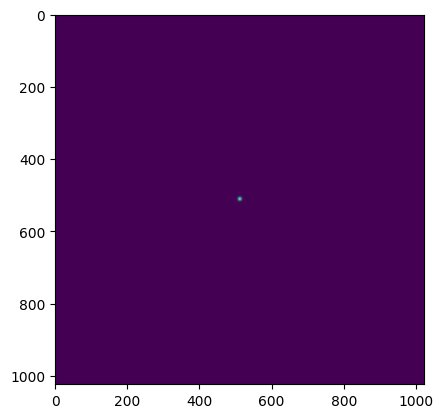

In [5]:
print(skymodel.shape)
print(pos_z)
plt.imshow(skymodel[int(pos_z[0])])


Read Antenna Function

In [6]:
cur_dir = '/Users/michele/Documents/GitHub/APSYNSIM'
model_dir = os.path.join(cur_dir, 'SOURCE_MODELS')
##antenna_dir = os.path.join(cur_dir, 'ARRAYS')
data_dir = os.path.join(cur_dir, 'PICTURES')
array_name = 'ALMA-test.array'
model_name = 'RadioGalaxy.model'

#antenna_file = os.path.join(antenna_dir, array_name)
Hfac = np.pi / 180. * 15.
deg2rad = np.pi / 180.
curzoom = [0, 0, 0, 0]
robust = 0.0
deltaAng = 1. * deg2rad
gamma = 0.5
lfac = 1.e6 
ulab = r'U (M$\lambda$)'
vlab = r'V (M$\lambda$)'
nH = 200
#Npix = 512
#Hcov = [-12.0 * Hfac, 12.0 * Hfac]
Hmax = np.pi
lat = -23.028 * deg2rad
#dec = -27.74  * deg2rad
trlat = [np.sin(lat), np.cos(lat)]
#trdec = [np.sin(dec), np.cos(dec)]
Xmax = 4.0
Diameters = [12., 0.]
#wavelength = [3.e-6, 21.e-5, 6.e-5]  # in km.
#antPos = []
#Hcov = [0, 0]
#Nant = 0
dec = dec * deg2rad
trdec = [np.sin(dec), np.cos(dec)]
#fi = open(antenna_file)
#for li, l in enumerate(fi.readlines()):
#    comm = l.find('#')
#    if comm >= 0:
#        l = l[:comm]
#    it = l.split()
#    if len(it) > 0:
        #if it[0] == 'WAVELENGTH':
        #    wavelength = [
        #        float(it[1]) * 1.e-3,
        #        float(it[2]) * 1.e-3
        #    ]
        #    wavelength.append(
        #        (wavelength[0] + wavelength[1]) / 2.)
        #elif it[0] == 'ANTENNA':
        #                   antPos.append(list(map(float, it[1:])))
        #                    Nant += 1
        #                    antPos[-1][0] *= 1.e-3
        #                    antPos[-1][1] *= 1.e-3
        #                    Xmax = np.max(np.abs(antPos[-1] + [Xmax]))
        #if it[0] == 'DIAMETER':
        #    Diams = list(map(float, it[1:]))
        #    Diameters[0] = Diams[0]
        #    if len(Diams) > 1:
        #        Diameters[1] = Diams[1]
        #elif it[0] == 'LATITUDE':
        #    lat = float(it[1]) * deg2rad
        #    trlat = [np.sin(lat), np.cos(lat)]
        #if it[0] == 'DECLINATION':
        #    dec = float(it[1]) * deg2rad
            #trdec = [np.sin(dec), np.cos(dec)]
        #if it[0] == 'HOUR_ANGLE':
        #    Hcov[0] = float(it[1]) * Hfac
        #    Hcov[1] = float(it[2]) * Hfac
#cosW = -np.tan(lat) * np.tan(dec)
#if np.abs(cosW) < 1.0:
##    Hhor = np.arccos(cosW)
#elif np.abs(lat - dec) > np.pi / 2.:
#    Hhor = 0
#else:
#    Hhor = np.pi
#print(Hhor)
#Hhor = Hhor.value
#if Hhor > 0.0:
#    if Hcov[0] < -Hhor:
##        Hcov[0] = -Hhor
 #   if Hcov[1] > Hhor:
#        Hcov[1] = Hhor

#Hmax = Hhor
#H = np.linspace(Hcov[0], Hcov[1],
#                nH)[np.newaxis, :]
#Xmax = Xmax * 1.5  
#fi.close()      
#antPos = [[-0.03389413 ,-0.71275165],
# [ 0.01593454 ,-0.70067575],
# [ 0.00948234 ,-0.68707647],
# [ 0.03782618 ,-0.73587608],
# [ 0.01073988 ,-0.65956736],
## [-0.02062042 ,-0.63390734],
# [-0.05940429 ,-0.66757174],
# [-0.07447462 ,-0.68465746],
# [-0.10543874 ,-0.75500336],
# [-0.02604186 ,-0.72618881],
# [-0.04233955 ,-0.77786071],
# [ 0.00238262 ,-0.76328556],
# [ 0.01710537 ,-0.7665338 ],
# [-0.08006703 ,-0.78037402],
# [-0.06350521 ,-0.78681996],
# [-0.019654   ,-0.79459523],
# [ 0.03035175 ,-0.77391881],
# [-0.00528917 ,-0.86285383],
# [-0.0795438  ,-0.8289398 ],
# [ 0.10809779 ,-0.76286664],
# [ 0.08909395 ,-0.5999597 ],
# [-0.20514905 ,-0.72468951],
# [ 0.10371666 ,-0.84799174],
# [-0.06264949 ,-0.51906584],
# [-0.13607045 ,-0.90208611],
# [-0.20162026 ,-0.50758514],
# [ 0.14960526 ,-0.49158347],
# [-0.32056523 ,-0.76386112],
# [ 0.21099834 ,-0.88346636],
# [-0.07116719 ,-0.42739351],
## [-0.11570636 ,-1.0754434 ],
# [-0.37097434 ,-0.60412373],
# [ 0.15950606 ,-1.06709435],
# [ 0.02889945 ,-0.30541708],
 #[-0.32252517 ,-1.00412553],
# [-0.40523552 ,-0.34214363],
# [-0.58898254 ,-0.5118804 ],
# [ 0.44201782 ,-1.21084073],
# [ 0.66449876 ,-0.65237277],
# [ 0.33621648 , 0.0475583 ],
# [ 0.38479195, -0.36745686]]

#Xmax = 4.0
#for i in range(len(antPos)):
#    Xmax = np.max(np.abs(antPos[-1] + [Xmax]))
#Xmax = Xmax * 1.5 
#Nant = len(antPos)
#print(Hcov)
#print(wavelength)
wavelength = [2.998854402755217e-06, 2.998861721889001e-06, 2.9988580623221087e-06]
print(wavelength)

[2.998854402755217e-06, 2.998861721889001e-06, 2.9988580623221087e-06]


In [7]:
def _hz_to_m(freq):
        c_ms = c.to(U.m / U.s).value
        return c_ms / freq

antenna_coordinates = pd.read_csv(os.path.join(main_dir, 'antenna_config', 'antenna_coordinates.csv'))
obs_antennas = antenna_array.split(' ')
obs_antennas = [antenna.split(':')[0] for antenna in obs_antennas]
obs_coordinates = antenna_coordinates[antenna_coordinates['name'].isin(obs_antennas)]
antenna_coordinates = obs_coordinates[['x', 'y']].values
antenna_coordinates = antenna_coordinates # convert to km
Nant = len(antenna_coordinates)

antPos = []
Xmax = 0.0
Hcov = [-3.0 * Hfac, 3.0 * Hfac]
for line in antenna_coordinates:
    antPos.append([line[0] * 1e-3, line[1] * 1e-3])
    Xmax = np.max(np.abs(antPos[-1] + [Xmax]))
Xmax = Xmax
antPos = antPos
Hcov = Hcov
cosW = -np.tan(lat) * np.tan(dec)
if np.abs(cosW) < 1.0:
    Hhor = np.arccos(cosW)
elif np.abs(lat - dec) > np.pi / 2.:
    Hhor = 0
else:
    Hhor = np.pi
Hhor = Hhor.value
if Hhor > 0.0:
    if Hcov[0] < -Hhor:
        Hcov[0] = -Hhor
    if Hcov[1] > Hhor:
        Hcov[1] = Hhor

Hmax = Hhor
H = np.linspace(Hcov[0], Hcov[1],
                nH)[np.newaxis, :]
Xmax = 4.0
for i in range(len(antPos)):
    Xmax = np.max(np.abs(antPos[-1] + [Xmax]))
Xmax = Xmax * 1.5 
Nant = len(antPos)
print(central_freq)

w_max, w_min = [_hz_to_m(freq) for freq in [central_freq.to(U.Hz).value - band_range.to(U.Hz).value / 2, central_freq.to(U.Hz).value + band_range.to(U.Hz).value / 2]]
waves = np.linspace(w_min, w_max, n_channels + 1)
obs_wavelengths = np.array([[waves[i], waves[i + 1] ] for i in range(len(waves) - 1)])
wavelength = list(obs_wavelengths[int(pos_z[0])] * 1e-3)
print(wavelength)
wavelength.append((wavelength[0] + wavelength[1]) / 2.)
print(wavelength)

100.0 GHz
[2.996319052449234e-06, 2.996348329027257e-06]
[2.996319052449234e-06, 2.996348329027257e-06, 2.9963336907382456e-06]


Read Model Function 

In [8]:
model_file = os.path.join(model_dir, model_name)
#imsize = 2 * 67. * 1.5
#fixsize = False
#models = []
#imfiles = []
#Xmax = 0.0
#print(model_file)
#fi = open(model_file)
#for li, l in enumerate(fi.readlines()):
#    comm = l.find('#')
#    if comm >= 0:
##        l = l[:comm]
#   it = l.split()
#    if len(it) > 0:
#        if it[0] == 'IMAGE':
#            imfiles.append([str(it[1]), float(it[2])])
#        elif it[0] in ['G', 'D', 'P']:
#            models.append([it[0]] + list(map(float, it[1:])))
#            if models[-1][0] != 'P':
#                models[-1][4] = np.abs(models[-1][4])
#                Xmax = np.max([
#                    np.abs(models[-1][1]) + models[-1][4],
#                    np.abs(models[-1][2]) + models[-1][4], Xmax
#                ])
#        elif it[0] == 'IMSIZE':
#            imsize = 2. * float(it[1])
#            fixsize = True
#        else:
#            showError(
#                "\n\nWRONG SYNTAX IN LINE %i:\n\n %s...\n\n" %
#                (li + 1, l[:max(10, len(l))]))

#if len(models) + len(imfiles) == 0:
#    showError(
#        "\n\nThere should be at least 1 model component!\n\n")

#models = models
#imsize = imsize
#imfiles = imfiles
#if not fixsize:
#    imsize = Xmax * 1.1



#fi.close()
imsize = 2 * 1.5 * fov.value
Xaxmax = imsize / 2.

Variable Initialization at the beginnining of GUI

In [9]:
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = 10 * np.outer(np.cos(u), np.sin(v))
y = 10 * np.outer(np.sin(u), np.sin(v))
z = 10 * np.outer(np.ones(np.size(u)), np.cos(v))
beta = np.zeros(100)
arrayPath = [
    np.zeros(nH),
    np.zeros(nH),
    np.zeros(nH)
]


currcmap = cm.jet
fmtH = r'$\phi = $ %3.1f$^\circ$   $\delta = $ %3.1f$^\circ$' "\n" r'H = %3.1fh / %3.1fh'
fmtBas = r'Bas %i $-$ %i  at  H = %4.2fh'
fmtVis = r'Amp: %.1e Jy.   Phase: %5.1f deg.'
fmtA = 'N = %i'
fmtA2 = '  Picked Ant. #%i'
fmtA3 = '\n%6.1fm | %6.1fm'
fmtB1 = r'$\lambda = $ %4.1fmm  ' % (wavelength[2] * 1.e6)
fmtB = fmtB1 + "\n" + r'% 4.2f Jy/beam' + "\n" + r'$\Delta\alpha = $ % 4.2f / $\Delta\delta = $ % 4.2f '
fmtD = r'% .2e Jy/beam' "\n" r'$\Delta\alpha = $ % 4.2f / $\Delta\delta = $ % 4.2f '
fmtM = r'%.2e Jy/pixel' "\n" r'$\Delta\alpha = $ % 4.2f / $\Delta\delta = $ % 4.2f'

In [10]:
Npix = skymodel.shape[1]
Nphf = Npix // 2
robfac = 0.0
W2W1 = 1

Prepare Beam Function 

In [11]:
beam = np.zeros((Npix, Npix), dtype=np.float32)
totsampling = np.zeros((Npix, Npix), dtype=np.float32)
dirtymap = np.zeros((Npix, Npix), dtype=np.float32)
noisemap = np.zeros((Npix, Npix), dtype=np.complex64)
robustsamp = np.zeros((Npix, Npix), dtype=np.float32)
Gsampling = np.zeros((Npix, Npix), dtype=np.complex64)
Grobustsamp = np.zeros((Npix, Npix), dtype=np.complex64)
GrobustNoise = np.zeros((Npix, Npix),dtype=np.complex64)
beam2 = np.zeros((Npix, Npix), dtype=np.float32)
totsampling2 = np.zeros((Npix, Npix), dtype=np.float32)
dirtymap2 = np.zeros((Npix, Npix), dtype=np.float32)
robustsamp2 = np.zeros((Npix, Npix), dtype=np.float32)

Prepare Baseline Function 

In [12]:
Nbas = Nant * (Nant - 1) // 2
NBmax = Nbas
B = np.zeros((NBmax, nH), dtype=np.float32)
basnum = np.zeros((Nant, Nant - 1), dtype=np.int8)
basidx = np.zeros((Nant, Nant), dtype=np.int8)
antnum = np.zeros((NBmax, 2), dtype=np.int8)
Gains = np.ones((Nbas, nH), dtype=np.complex64)
Noise = np.zeros((Nbas, nH), dtype=np.complex64)
Horig = np.linspace(Hcov[0], Hcov[1], nH)
H = Horig[np.newaxis, :]
H = [np.sin(H), np.cos(H)]
bi = 0
nii = [0 for n in range(Nant)]
for n1 in range(Nant - 1):
    for n2 in range(n1 + 1, Nant):
        basnum[n1, nii[n1]] = np.int8(bi)
        basnum[n2, nii[n2]] = np.int8(bi)
        basidx[n1, n2] = np.int8(bi)
        antnum[bi] = [n1, n2]
        nii[n1] += 1
        nii[n2] += 1
        bi += np.int8(1)
u = np.zeros((NBmax, nH))
v = np.zeros((NBmax, nH))
ravelDims = (NBmax, nH)

Set Baselines Function 

In [13]:
antidx = -1 
if antidx == -1:
        bas2change = range(Nbas)
elif antidx < Nant:
    bas2change = basnum[antidx].flatten()
else:
    bas2change = []
for currBas in bas2change:
    n1, n2 = antnum[currBas]
    B[currBas, 0] = -(antPos[n2][1] - antPos[n1][1]) \
                         * trlat[0] / wavelength[2]
    B[currBas, 1] = (antPos[n2][0] - antPos[n1][0]) \
                         / wavelength[2]
    B[currBas, 2] = (antPos[n2][1] - antPos[n1][1]) \
                         * trlat[1] / wavelength[2]
    u[currBas, :] = -(B[currBas, 0] * H[0] + B[currBas, 1] * H[1])
    v[currBas, :] = -B[currBas, 0] * trdec[0] * H[1] \
                         + B[currBas, 1] * trdec[0] * H[0] \
                         + trdec[1] * B[currBas, 2]

Grid UV Function 

In [14]:
if antidx == -1:
    bas2change = range(Nbas)
    pixpos = [[] for nb in bas2change]
    totsampling[:] = 0.0
    Gsampling[:] = 0.0
    noisemap[:] = 0.0
elif antidx < Nant:
    bas2change = list(map(int, list(basnum[antidx].flatten())))
else:
    bas2change = []
UVpixsize = 2. / (imsize * np.pi / 180. / 3600.)
for nb in bas2change:
    pixU = np.rint(u[nb] / UVpixsize).flatten().astype(
        np.int32)
    pixV = np.rint(v[nb] / UVpixsize).flatten().astype(
        np.int32)
    goodpix = np.where(
        np.logical_and(
            np.abs(pixU) < Nphf,
            np.abs(pixV) < Nphf))[0]
    pU = pixU[goodpix] + Nphf
    pV = pixV[goodpix] + Nphf
    mU = -pixU[goodpix] + Nphf
    mV = -pixV[goodpix] + Nphf
    if antidx != -1:
        totsampling[pixpos[nb][1], pixpos[nb][2]] -= 1.0
        totsampling[pixpos[nb][3], pixpos[nb][0]] -= 1.0
        Gsampling[pixpos[nb][1], 
                       pixpos[nb][2]] -= Gains[nb, goodpix]
        Gsampling[pixpos[nb][3], 
                       pixpos[nb][0]] -= np.conjugate(
                           Gains[nb, goodpix])
        noisemap[pixpos[nb][1], pixpos[nb]
                      [2]] -= Noise[nb, goodpix] * np.abs(
                          Gains[nb, goodpix])
        noisemap[pixpos[nb][3], 
                      pixpos[nb][0]] -= np.conjugate(
                          Noise[nb, goodpix]) * np.abs(
                              Gains[nb, goodpix])
    pixpos[nb] = [
        np.copy(pU),
        np.copy(pV),
        np.copy(mU),
        np.copy(mV)
    ]
    for pi, gp in enumerate(goodpix):
        gabs = np.abs(Gains[nb, gp])
        pVi = pV[pi]
        mUi = mU[pi]
        mVi = mV[pi]
        pUi = pU[pi]
        totsampling[pVi, mUi] += 1.0
        totsampling[mVi, pUi] += 1.0
        Gsampling[pVi, mUi] += Gains[nb, gp]
        Gsampling[mVi, pUi] += np.conjugate(Gains[nb, gp])
        noisemap[pVi, mUi] += Noise[nb, gp] * gabs
        noisemap[mVi, pUi] += np.conjugate(
            Noise[nb, gp]) * gabs
robfac = (5. * 10.**(-robust))**2. * (
    2. * Nbas * nH) / np.sum(totsampling**2.)


Set Beam Function (be aware that the first line of this function would be gridUV function)

In [15]:

denom = 1. + robfac * totsampling
robustsamp[:] = totsampling / denom
Grobustsamp[:] = Gsampling / denom
GrobustNoise[:] = noisemap / denom
beam[:] = np.fft.ifftshift(
    np.fft.ifft2(np.fft.fftshift(
        robustsamp))).real / (1. + W2W1)
beamScale = np.max(beam[Nphf:Nphf +1, Nphf:Nphf + 1])
beam[:] /= beamScale

Plot Beam Function 

396000.0
1623.0


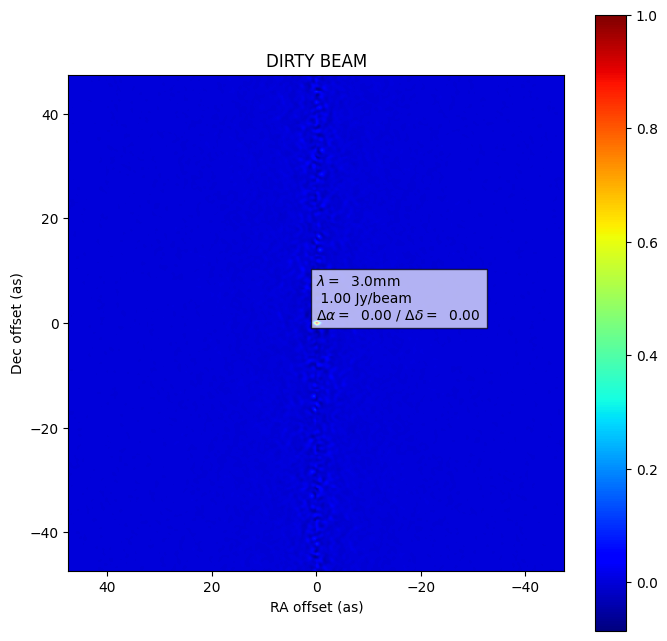

In [16]:
Np4 = Npix // 4
beamPlot = plt.figure(figsize=(8, 8))
beamPlotPlot = plt.imshow(
    beam[Np4:Npix - Np4, Np4:Npix - Np4],
    picker=True,
    interpolation='nearest',
    cmap=currcmap)
beamText = plt.text(
    0.05,
    0.80,
    fmtB % (1.0, 0.0, 0.0),
    bbox=dict(facecolor='white', alpha=0.7))
plt.ylabel('Dec offset (as)')
plt.xlabel('RA offset (as)')
plt.setp(beamPlotPlot,
        extent=(Xaxmax / 2., -Xaxmax / 2.,
                -Xaxmax / 2., Xaxmax / 2.))
curzoom[0] = (Xaxmax / 2., -Xaxmax / 2.,
                   -Xaxmax / 2., Xaxmax / 2.)
plt.title('DIRTY BEAM')
plt.colorbar()
nptot = np.sum(totsampling[:])
beamPlotPlot.norm.vmin = np.min(beam)
beamPlotPlot.norm.vmax = 1.0
print(nptot)
print(np.sum(totsampling[Nphf - 4:Nphf + 4, Nphf -
                           4:Nphf + 4]))
if np.sum(totsampling[Nphf - 4:Nphf + 4, Nphf -
                           4:Nphf + 4]) == nptot:
    warn = 'WARNING!\nToo short baselines for such a small image\nPLEASE, INCREASE THE IMAGE SIZE!\nAND/OR DECREASE THE WAVELENGTH'
    beamText.set_text(warn)
arrayPath[0][:] = 10. * H[1] * np.cos(lat)
arrayPath[1][:] = 10. * H[0] * np.cos(lat)
arrayPath[2][:] = 10. * np.sin(lat)

plt.show()


Plot Antennas


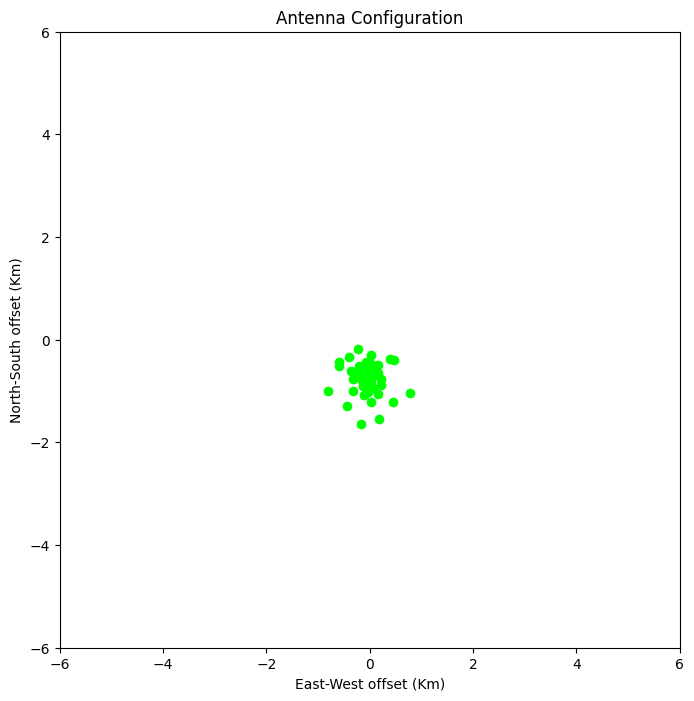

-6.0 6.0


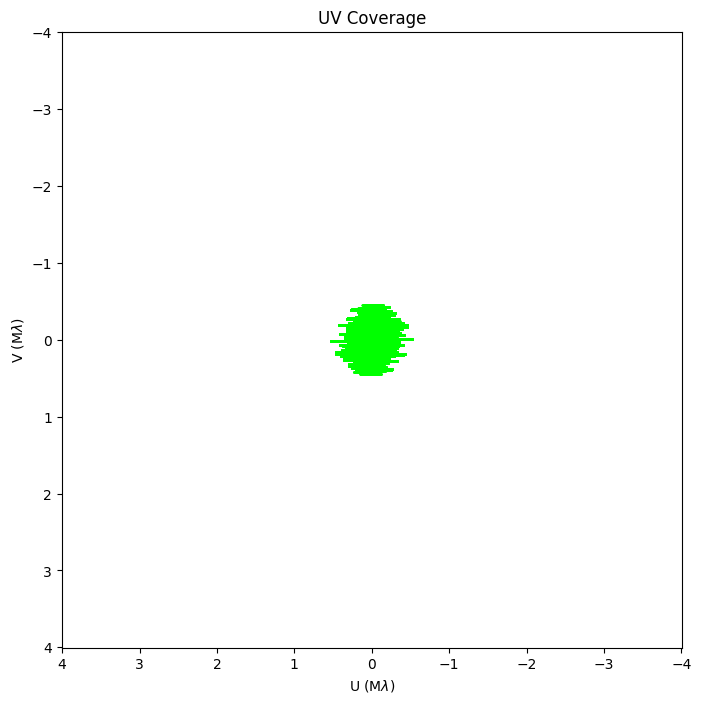

In [17]:
antPlot = plt.figure(figsize=(8, 8))
mw = 2. * Xmax / wavelength[2] / lfac
if mw < 0.1 and lfac == 1.e6:
    lfac = 1.e3
    ulab = r'U (k$\lambda$)'
    vlab = r'V (k$\lambda$)'
elif mw >= 100. and lfac == 1.e3:
    lfac = 1.e6
    ulab = r'U (M$\lambda$)'
    vlab = r'V (M$\lambda$)'
toplot = np.array(antPos[:Nant])
antPlotBas = plt.plot([0], [0], '-b')[0]
antPlotPlot = plt.plot(toplot[:, 0], toplot[:, 1],
                                            'o',
                                            color='lime',
                                            picker=5)[0]


plt.xlim(-Xmax, Xmax)
plt.ylim(-Xmax, Xmax)
plt.xlabel('East-West offset (Km)')
plt.ylabel('North-South offset (Km)')
plt.title('Antenna Configuration')
plt.show()
print(-Xmax, Xmax)

UVPlot = plt.figure(figsize=(8, 8))
UVPlotPlot = []
toplotu = u.flatten() / lfac
toplotv = v.flatten() / lfac
UVPlotPlot.append(
    plt.plot(toplotu,
                     toplotv,
                     '.',
                     color='lime',
                     markersize=1,
                     picker=2)[0])
UVPlotPlot.append(
    plt.plot(-toplotu,
                     -toplotv,
                     '.',
                     color='lime',
                     markersize=1,
                     picker=2)[0])
plt.xlim((2. * Xmax / wavelength[2] / lfac,
                 -2. * Xmax / wavelength[2] / lfac))
plt.ylim((2. * Xmax / wavelength[2] / lfac,
                 -2. * Xmax / wavelength[2] / lfac))
plt.xlabel(ulab)
plt.ylabel(vlab)
plt.title('UV Coverage')
plt.show()

Prepare Model Function 

In [18]:
print(skymodel.shape)
pixsize = float(imsize) / Npix
xx = np.linspace(-imsize / 2., imsize / 2., Npix)
yy = np.ones(Npix, dtype=np.float32)
distmat = np.zeros((Npix, Npix), dtype=np.float32)
modelim = [np.zeros((Npix, Npix), dtype=np.float32) for i in [0, 1]]
modelimTrue = np.zeros((Npix, Npix), dtype=np.float32)
#for model in models:
#    xsh = -model[1]
#    ysh = -model[2]
#    xpix = np.rint(xsh / pixsize).astype(np.int32)
#    ypix = np.rint(ysh / pixsize).astype(np.int32)
#    centy = np.roll(xx, ypix)
#    centx = np.roll(xx, xpix)
#    distmat[:] = np.outer(centy**2., yy) + np.outer(yy, centx**2.)
#    if model[0] == 'D':
#        mask = np.logical_or(distmat <= model[4]**2.,
#                             distmat == np.min(distmat))
#        modelimTrue[mask] += float(model[3]) / np.sum(mask)
##    elif model[0] == 'G':
 #       gauss = np.exp(-distmat / (2. * model[4]**2.))
#        modelimTrue[:] += float(model[3]) * gauss / np.sum(gauss)
#    elif model[0] == 'P':
#        if np.abs(xpix + Nphf) < Npix and np.abs(
#                ypix + Nphf) < Npix:
#            yint = ypix + Nphf
#            xint = xpix + Nphf
#            modelimTrue[yint, xint] += float(model[3])
#print(imfiles)
#for imfile in imfiles:
#    if not os.path.exists(imfile[0]):
#        imfile[0] = os.path.join(data_dir, imfile[0])
#        if not os.path.exists(imfile[0]):
#            showError(message=
#                'File %s does NOT exist. Cannot read the model!' %
#                imfile[0])
Np4 = Npix // 4
    # ADDED IT MYSELF
zoomimg = 0
    #img = plimg.imread(imfile[0]).astype(np.float32)
img = skymodel[int(pos_z[0])]
print(img.shape)
dims = np.shape(img)
    #d3 = min(2, dims[2])
    #d1 = float(max(dims))
    #avimg = np.average(img[:, :, :d3], axis=2)
    #avimg -= np.min(avimg)
d1 = img.shape[0]
avimg = img
    #avimg *= imfile[1] / np.max(avimg)
print(d1, Nphf)
if d1 == Nphf:
    sh0 = (Nphf - dims[0]) // 2
    sh1 = (Nphf - dims[1]) // 2
    modelimTrue[sh0 + Np4:sh0 + Np4 + dims[0], sh1 + Np4:sh1 +
                         Np4 + dims[1]] += zoomimg
else:
    zoomimg = spndint.zoom(avimg, float(Nphf) / d1)
    zdims = np.shape(zoomimg)
    zd0 = min(zdims[0], Nphf)
    zd1 = min(zdims[1], Nphf)
    sh0 = (Nphf - zdims[0]) // 2
    sh1 = (Nphf - zdims[1]) // 2
    modelimTrue[sh0 + Np4:sh0 + Np4 + zd0, sh1 + Np4:sh1 +
                         Np4 + zd1] += zoomimg[:zd0, :zd1]

modelimTrue[modelimTrue < 0.0] = 0.0
xx = np.linspace(-imsize / 2., imsize / 2., Npix)
yy = np.ones(Npix, dtype=np.float32)
distmat = (-np.outer(xx**2., yy) -
                np.outer(yy, xx**2.)) * pixsize**2.

# here the setPrimaryBeam Function runs
# _setPrimaryBeam(replotFFT=True)

(256, 1024, 1024)
(1024, 1024)
1024 512


/var/folders/66/76q50s015tq8wc5qz1pvg7y40000gn/T/ipykernel_99297/2412719349.py:58: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  zoomimg = spndint.zoom(avimg, float(Nphf) / d1)


Set Primary Beam Function 

In [19]:
if Diameters[0] > 0.0:
    PB = 2. * (1220. * 180. / np.pi * 3600. * wavelength[2] /
               Diameters[0] / 2.3548)**2.
    beamImg = np.exp(distmat / PB)
    modelim[0][:] = modelimTrue * beamImg
else:
    modelim[0][:] = modelimTrue
modelfft = np.fft.fft2(np.fft.fftshift(modelim[0]))
modelfft2 = np.fft.fft2(np.fft.fftshift(modelim[1]))

Plot Model Function 

Text(0.5, 1.0, 'MODEL IMAGE: 4.48e-03 Jy')

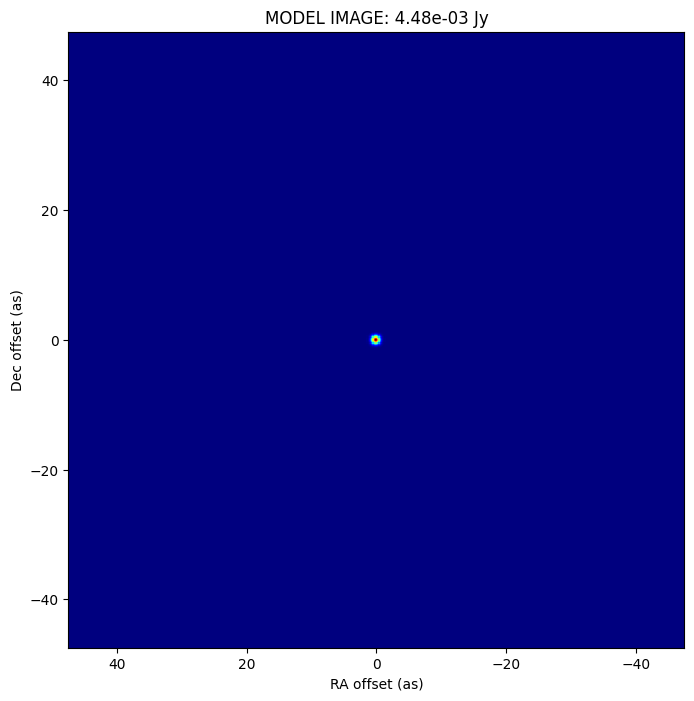

In [20]:
Np4 = Npix // 4
modelPlot = plt.figure(figsize=(8, 8))
modelPlotPlot = plt.imshow(
    np.power(
        modelimTrue[Np4:Npix - Np4, Np4:Npix - Np4],
        gamma),
    picker=True,
    interpolation='nearest',
    vmin=0.0,
    vmax=np.max(modelimTrue)**gamma,
    cmap=currcmap)

modflux = modelimTrue[Nphf, Nphf]
plt.setp(modelPlotPlot,
        extent=(Xaxmax / 2., -Xaxmax / 2.,
                -Xaxmax / 2., Xaxmax / 2.))
plt.ylabel('Dec offset (as)')
plt.xlabel('RA offset (as)')
totflux = np.sum(modelimTrue[Np4:Npix -Np4, Np4:Npix - Np4])
plt.title('MODEL IMAGE: %.2e Jy' % totflux)

Plot Dirty Function

Text(0.5, 1.0, 'DIRTY IMAGE')

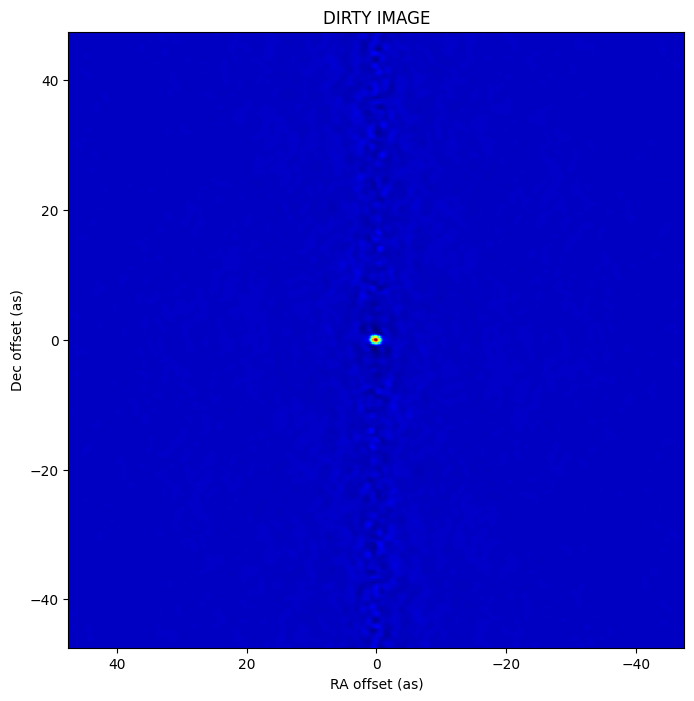

In [21]:
dirtyPlot = plt.figure(figsize=(8, 8))
Np4 = Npix // 4
dirtymap[:] = (np.fft.fftshift(
    np.fft.ifft2(
        np.fft.ifftshift(GrobustNoise) + modelfft *
        np.fft.ifftshift(Grobustsamp)))).real / (1. + W2W1)
dirtymap /= beamScale       
extr = [np.min(dirtymap), np.max(dirtymap)]
dirtyPlotPlot = plt.imshow(
                dirtymap[Np4:Npix - Np4, Np4:Npix - Np4],
                interpolation='nearest',
                picker=True,
                cmap=currcmap)
modflux = dirtymap[Nphf, Nphf]
plt.setp(dirtyPlotPlot,
                    extent=(Xaxmax / 2., -Xaxmax / 2.,
                            -Xaxmax / 2., Xaxmax / 2.))
plt.ylabel('Dec offset (as)')
plt.xlabel('RA offset (as)')
plt.title('DIRTY IMAGE')

Plot Model FFT Function 


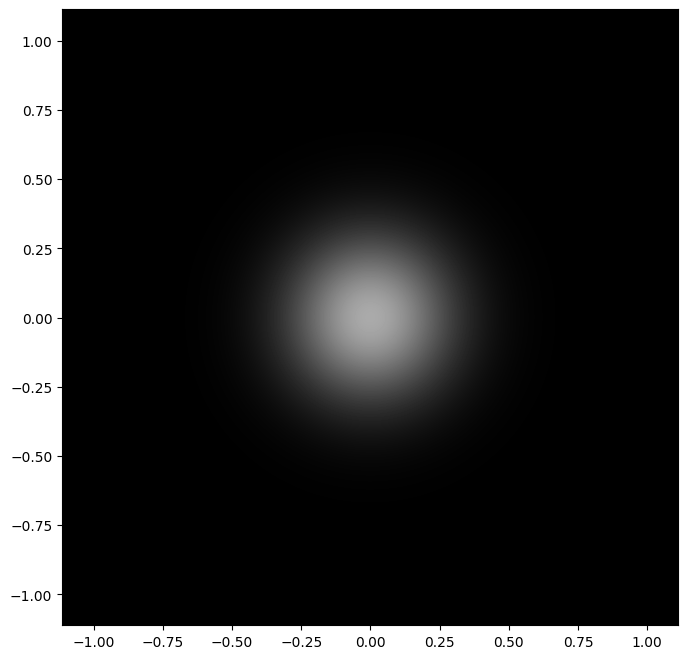

In [22]:
UVPlot = plt.figure(figsize=(8, 8))
UVmax = Npix / 2. / lfac * UVpixsize
UVSh = -UVmax / Npix
FFTtoplot = np.fft.fftshift(modelfft)
toplot = np.abs(FFTtoplot)
mval = np.min(toplot)
Mval = np.max(toplot)
dval = (Mval - mval) / 2.
mymap = plt.gray()
UVPlotFFTPlot = plt.imshow(toplot,
                               cmap=mymap,
                               vmin=0.0,
                               vmax=Mval + dval,
                               picker=5)
plt.setp(UVPlotFFTPlot,
    extent=(-UVmax + UVSh, UVmax + UVSh,
            -UVmax - UVSh, UVmax - UVSh))
plt.show()      